# HW7

## Импортируем библеотеки

In [88]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_blobs, make_moons, make_circles, make_classification
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm
import warnings
warnings.simplefilter("ignore", UserWarning)

# PART 1
## EDA

In [89]:
data = pd.read_csv("german_credit_data.csv")

In [90]:
data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


### Удалим ненужное

In [91]:
data = data.drop(['Unnamed: 0', 'Purpose'], axis = 1)

In [92]:
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration
0,67,male,2,own,NaN,little,1169,6
1,22,female,2,own,little,moderate,5951,48
2,49,male,1,own,little,NaN,2096,12
3,45,male,2,free,little,little,7882,42
4,53,male,2,free,little,little,4870,24


### Проверим на предмет пропусков

In [93]:
np.round(data.isna().sum()[data.isna().sum()>0] / data.shape[0], 2)

Saving accounts     0.18
Checking account    0.39
dtype: float64

In [94]:
print(f'При удалении пропусков данных останется {100*data.dropna().shape[0] / data.shape[0]} %')

При удалении пропусков данных останется 52.2 %


### Пропуски необходимо заполнить

In [95]:
data.fillna('', inplace=True)

### Преобразуем строковые данные в числовые 

In [96]:
data_old = data
data = data.apply(LabelEncoder().fit_transform)

In [97]:
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration
0,48,1,2,1,0,1,142,2
1,3,0,2,1,1,2,770,29
2,30,1,1,1,1,0,390,8
3,26,1,2,0,1,1,848,26
4,34,1,2,0,1,1,734,17


### Маштабируем данные для унификации

In [98]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.to_numpy())
data_scaled = pd.DataFrame(data_scaled, columns=[
  'Age','Sex','Job','Housing', 'Saving accounts','Checking account','Credit amount','Duration'])

In [99]:
data_scaled.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration
0,2.788510,0.670280,0.146949,-0.133710,-1.231393,-0.001045,-1.156695,-1.558464
1,-1.197733,-1.491914,0.146949,-0.133710,-0.196609,1.044372,1.217641,2.032467
2,1.194013,0.670280,-1.383771,-0.133710,-0.196609,-1.046463,-0.219059,-0.760479
3,0.839680,0.670280,0.146949,-2.016956,-0.196609,-0.001045,1.512543,1.633475
4,1.548345,0.670280,0.146949,-2.016956,-0.196609,-0.001045,1.081533,0.436498


# PART 2

### Снизим размерность для визуализации

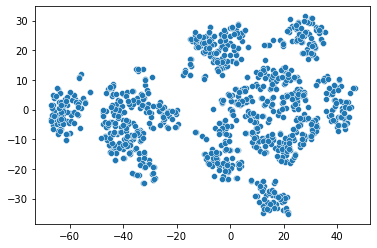

In [100]:
tsne = TSNE(n_components=2, random_state=10)
data_tsne = tsne.fit_transform(data_scaled)
sns.scatterplot(x=data_tsne[:,0], y=data_tsne[:,1]);

## Clustering

### K-means

Best result with 2 clusters


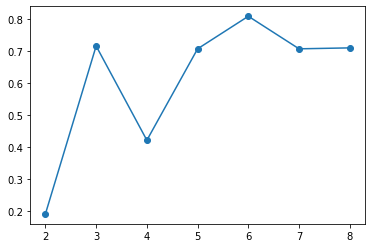

In [101]:
inertia = []
D = []
for i in range(1,10):
    kmeans = KMeans(n_clusters=i, random_state=10).fit(data_tsne)
    inertia_i = kmeans.inertia_
    inertia.append(inertia_i)
    

for i in range(1,8):
    Di = (inertia[i] - inertia[i+1]) / (inertia[i-1] - inertia[i])
    D.append(Di)
    
plt.plot(range(2,9), D, marker='o');
print(f'Best result with {range(2,9)[np.argmin(D)]} clusters')

##### Выбираем 2 кластера и строим график

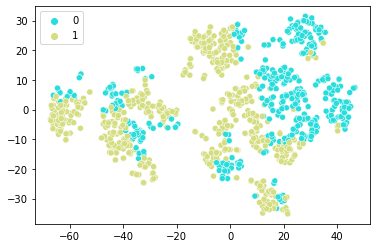

In [102]:
kmeans = KMeans(n_clusters=2, random_state=10).fit(data_scaled)
labels = kmeans.labels_
sns.scatterplot(x=data_tsne[:,0], y=data_tsne[:,1], hue=labels, palette='rainbow');

1    0.575
0    0.425
Name: labels, dtype: float64


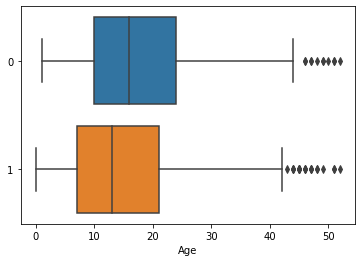

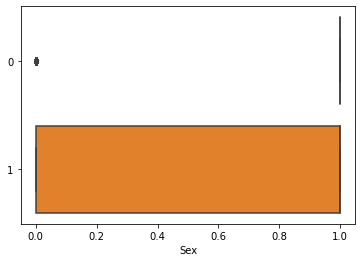

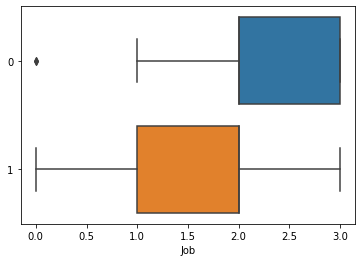

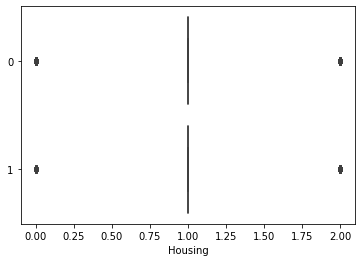

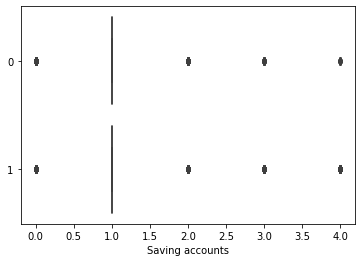

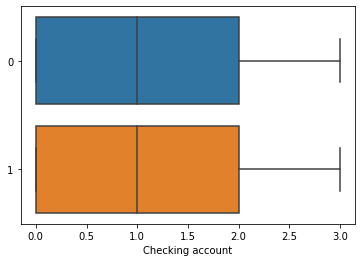

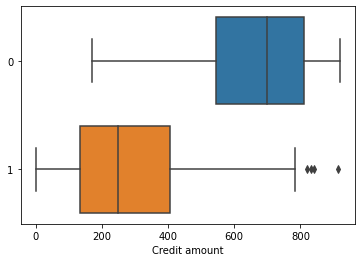

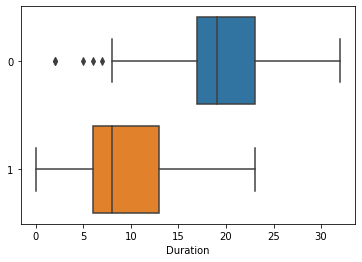

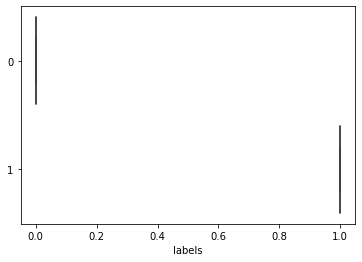

labels,0,1
Age,16.0,13.0
Sex,1.0,1.0
Job,2.0,2.0
Housing,1.0,1.0
Saving accounts,1.0,1.0
Checking account,1.0,1.0
Credit amount,699.0,249.0
Duration,19.0,8.0


In [103]:
data['labels'] = labels
print(data['labels'].value_counts(normalize=True))
for col in data.columns:
    sns.boxplot(data=data, x=col, y=labels, orient='h')
    plt.show();
data.groupby('labels').median().T.round(2)

### Hierarchical / Agglomerative clustering

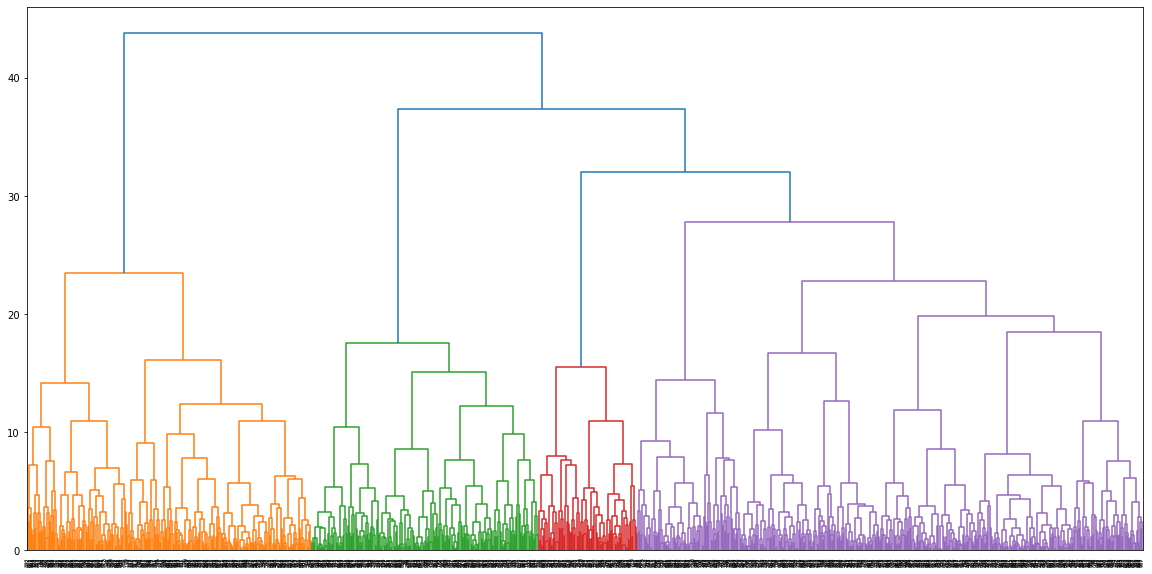

In [104]:
plt.figure(figsize=(20,10))
linkage_ = linkage(data_scaled, method='ward')
dendrogram_ = dendrogram(linkage_)

100%|██████████| 9/9 [00:00<00:00, 14.08it/s]


Best result with 2 clusters


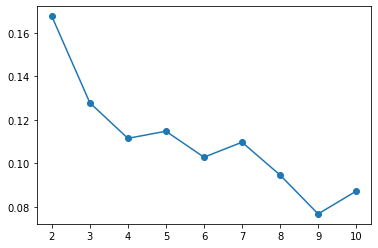

In [105]:
silhouette = []
for i in tqdm(range(2,11)):
    agg = AgglomerativeClustering(n_clusters=i).fit(data_tsne)
    labels = agg.labels_
    score = silhouette_score(data_scaled, labels)
    silhouette.append(score)
    
plt.plot(range(2,11), silhouette, marker='o');
print(f'Best result with {range(2,11)[np.argmax(silhouette)]} clusters')

##### Выбираем 2 кластера и строим график

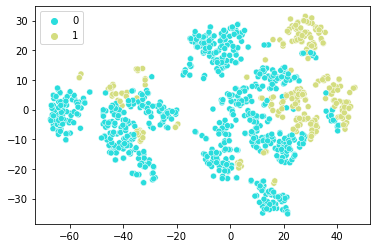

In [106]:
agg = AgglomerativeClustering(n_clusters=range(2,11)[np.argmax(silhouette)]).fit(data_scaled)
labels = agg.labels_
sns.scatterplot(x=data_tsne[:,0], y=data_tsne[:,1], hue=labels, palette='rainbow');

0    0.745
1    0.255
Name: labels, dtype: float64


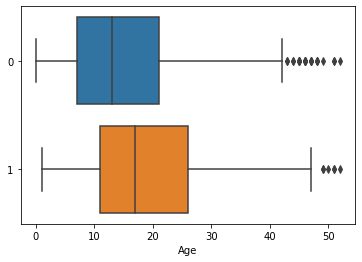

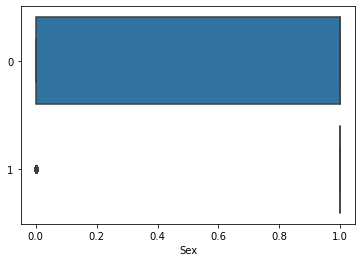

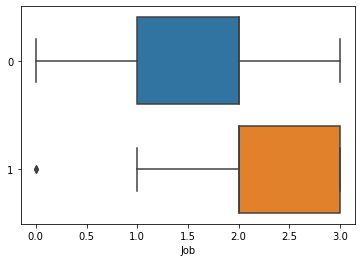

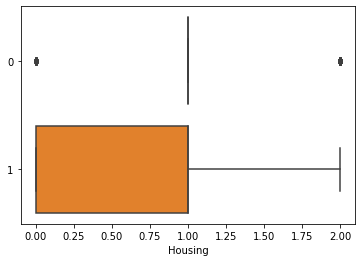

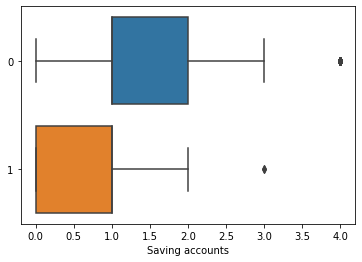

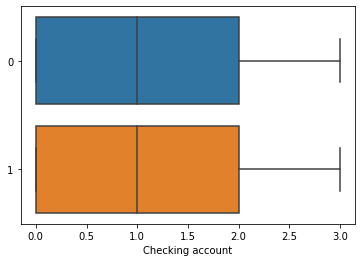

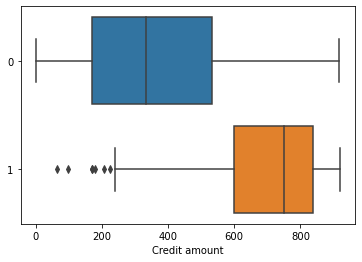

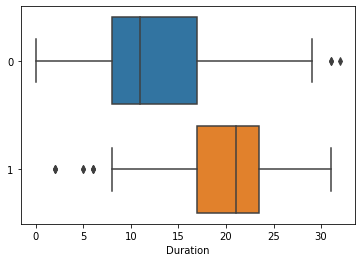

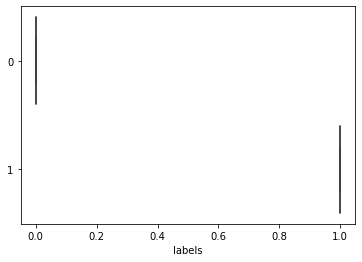

labels,0,1
Age,13.0,17.0
Sex,1.0,1.0
Job,2.0,2.0
Housing,1.0,1.0
Saving accounts,1.0,1.0
Checking account,1.0,1.0
Credit amount,333.0,749.0
Duration,11.0,21.0


In [107]:
data['labels'] = labels
print(data['labels'].value_counts(normalize=True))
for col in data.columns:
    sns.boxplot(data=data, x=col, y=labels, orient='h')
    plt.show();
data.groupby('labels').median().T.round(2)

### DBSCAN

#### Определям лучший EPS через метод NearestNeighbors

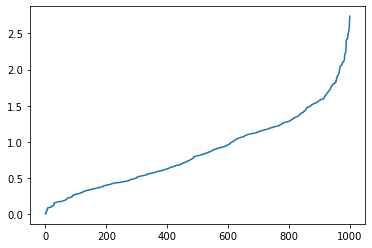

In [108]:
neighbors = NearestNeighbors(n_neighbors=5)
nbrs = neighbors.fit(data_scaled)
distance, indices = nbrs.kneighbors(data_scaled)

distance = np.sort(distance, axis=0)
distance = distance[:,1]
plt.plot(distance);

#### Возьмем EPS 1.6 и построим графики

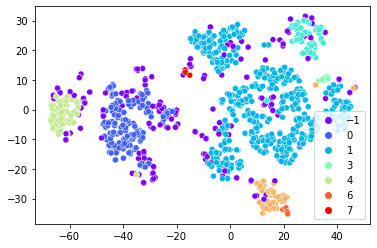

In [109]:
dbscan = DBSCAN(eps=1.6).fit(data_scaled)
labels = dbscan.labels_
sns.scatterplot(x=data_tsne[:,0], y=data_tsne[:,1], hue=labels, palette='rainbow');

 1    0.490
-1    0.166
 0    0.159
 4    0.064
 2    0.058
 5    0.045
 3    0.007
 6    0.007
 7    0.004
Name: labels, dtype: float64


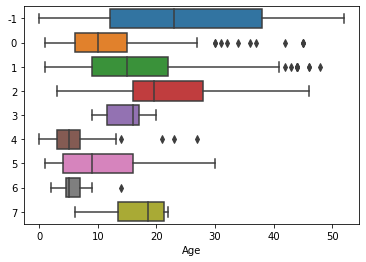

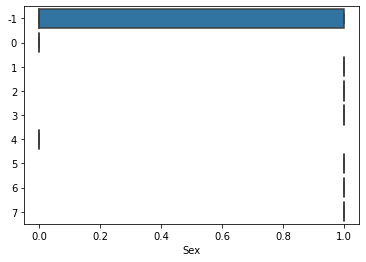

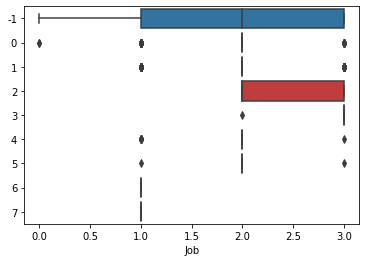

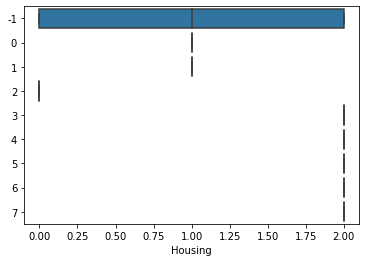

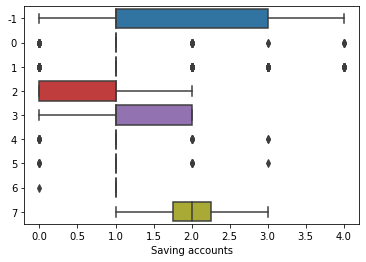

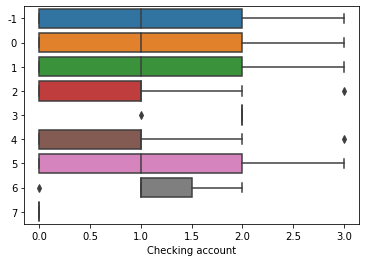

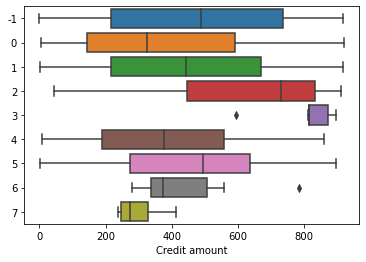

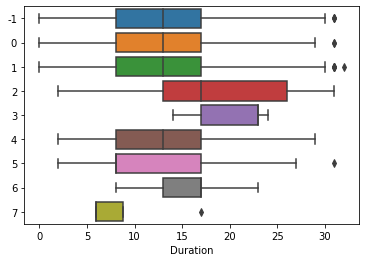

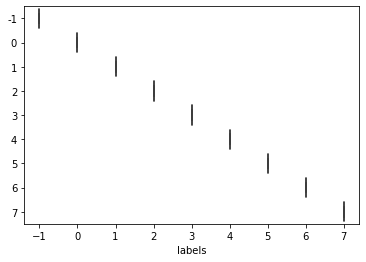

In [110]:
data['labels'] = labels
print(data['labels'].value_counts(normalize=True))
for col in data.columns:
    sns.boxplot(data=data, x=col, y=labels, orient='h')
    plt.show();

In [111]:
data.groupby('labels').median().T.round(2)

labels,-1,0,1,2,3,4,5,6,7
Age,23.0,10.0,15.0,19.5,16.0,5.0,9.0,5.0,18.5
Sex,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
Job,2.0,2.0,2.0,2.0,3.0,2.0,2.0,1.0,1.0
Housing,1.0,1.0,1.0,0.0,2.0,2.0,2.0,2.0,2.0
Saving accounts,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0
Checking account,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0
Credit amount,488.0,324.0,442.5,731.5,816.0,377.0,495.0,374.0,274.0
Duration,13.0,13.0,13.0,17.0,23.0,13.0,8.0,17.0,6.0


# Выводы


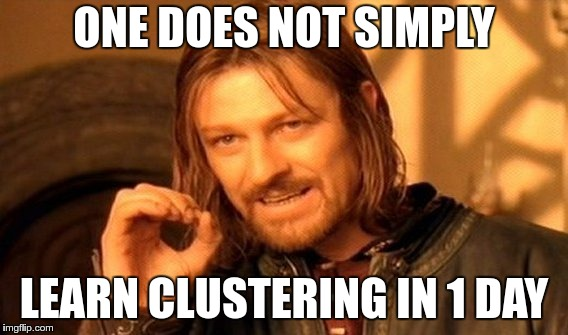


Наиболее интерсное разбиение показал метод DBSCAN, разбив данные на 8 кластеров, плюс 16% шума.

Остальные методы предложили лучшее разбиение на 2 класте, основываясь на сумме кредита